In [1]:
"""
TO BE ADDED:

- GridSearchCV
- Feature importance

"""


# Data wrangling libraries
import pandas as pd
import numpy as np

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing libraries
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_predict

# Regression libraries
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


# Metric libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
df = pd.read_csv("data_cleaned.csv")
df = df.drop(columns=['type', 'buildingcondition', 'epcscore', 'region', 'province', 'locality', 'postcode'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38701 entries, 0 to 38700
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bedroomcount               38701 non-null  float64
 1   habitablesurface           38701 non-null  float64
 2   haslift                    38701 non-null  int64  
 3   hasgarden                  38701 non-null  int64  
 4   hasswimmingpool            38701 non-null  int64  
 5   hasterrace                 38701 non-null  int64  
 6   price                      38701 non-null  float64
 7   epcscore_encoded           38701 non-null  float64
 8   buildingcondition_encoded  38701 non-null  float64
 9   region_Brussels            38701 non-null  float64
 10  region_Flanders            38701 non-null  float64
 11  region_Wallonia            38701 non-null  float64
 12  type_encoded               38701 non-null  int64  
dtypes: float64(8), int64(5)
memory usage: 3.8 MB


In [3]:
df_all = df
df_hs = df[df['type_encoded'] == 1]  # Houses
df_apt = df[df['type_encoded'] == 0]  # Apartments

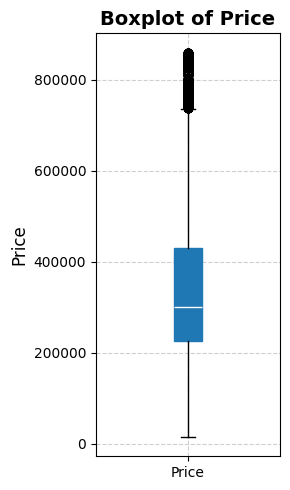

In [4]:
target = 'price'

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 5))
plt.boxplot(df[target], patch_artist=True, boxprops=dict(facecolor='#1f77b4', color='#1f77b4'),
            medianprops=dict(color='white'))

plt.title(f'Boxplot of {target.capitalize()}', fontsize=14, fontweight='bold')
plt.ylabel(target.capitalize(), fontsize=12)
plt.xticks([1], [target.capitalize()])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [5]:
def splitDF(df, target):
    # Select target
    y = df[target]
    # Select predictors
    X = df.drop([target], axis=1)
    return X, y


In [6]:
def regResults(df, name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Append metrics to results list
    results.append({
        "Dataset": df,
        "Model": name,
        "R² Score": r2,
        "MAE": mae,
        "RMSE": rmse
    })


In [7]:
def plotPredictions(df, name, y_true, y_pred):
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r')
    plt.title(f"{name} - {df} — Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# REGRESSION MODELS

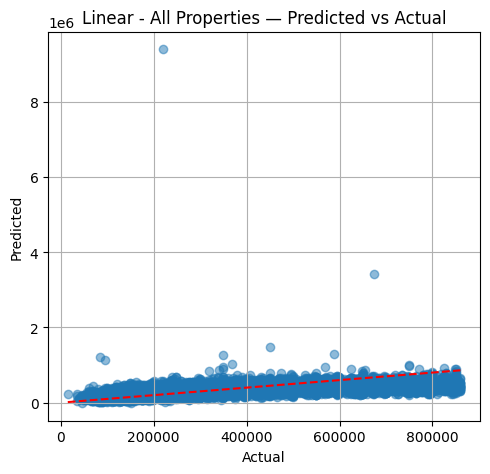

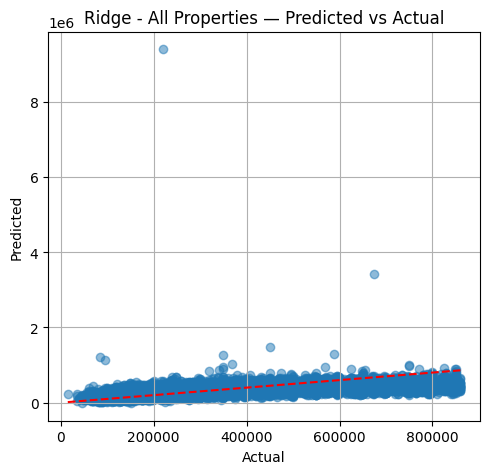

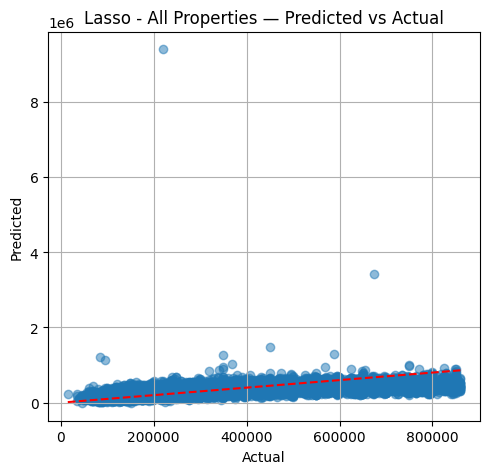

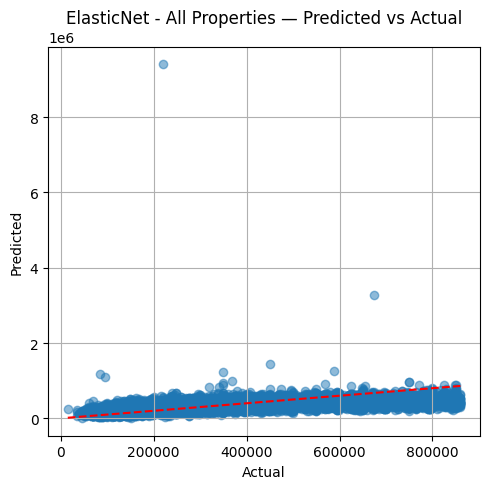

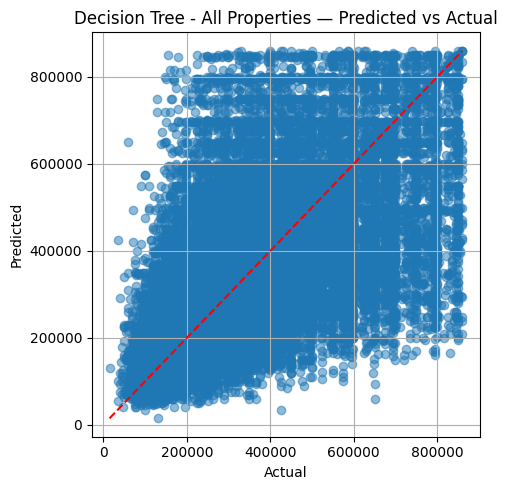

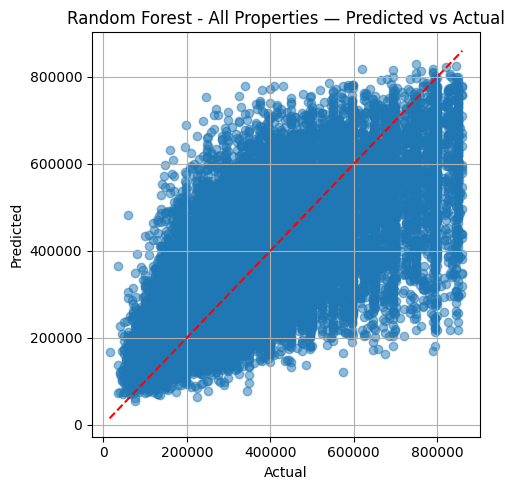

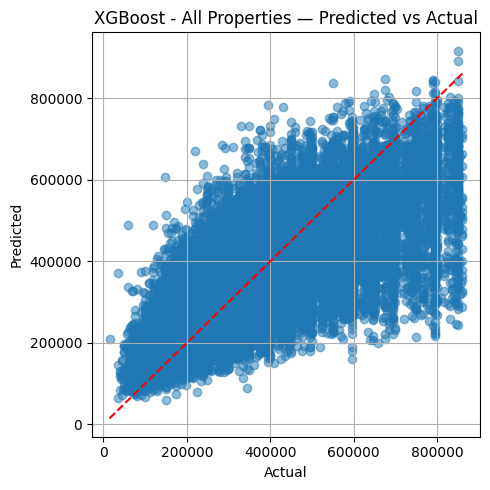

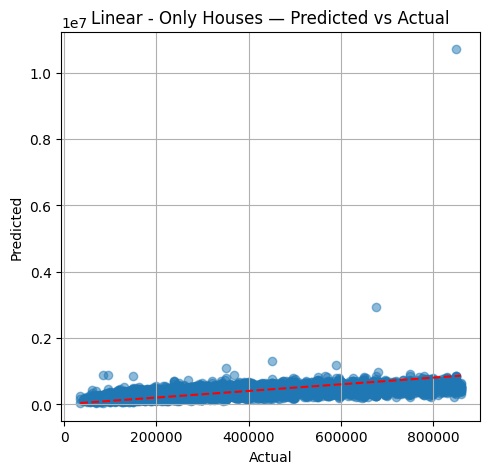

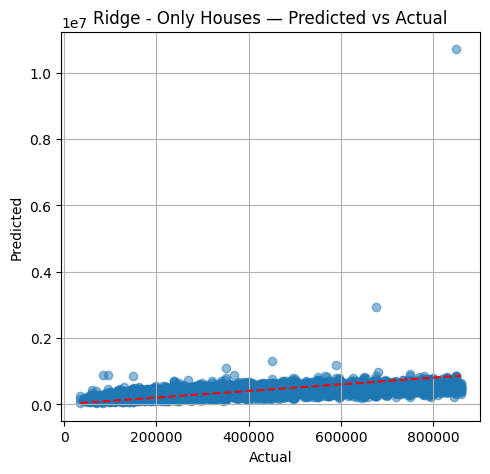

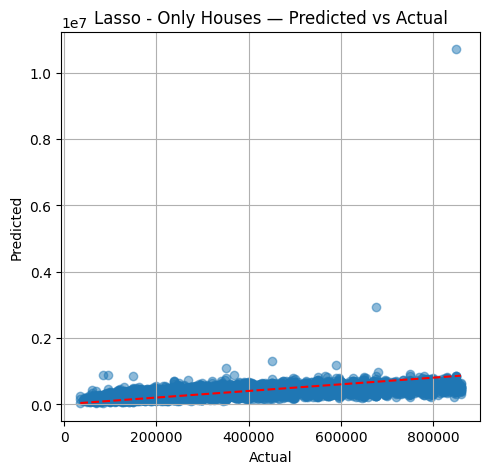

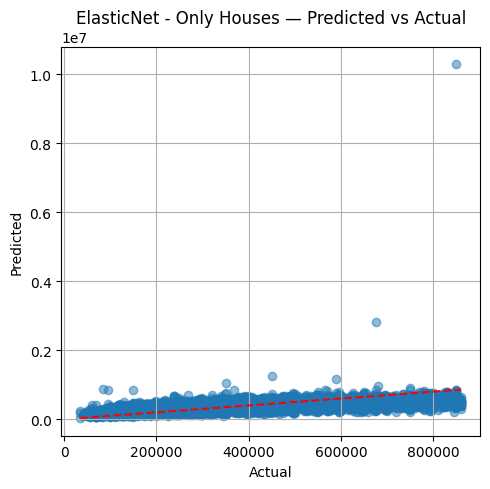

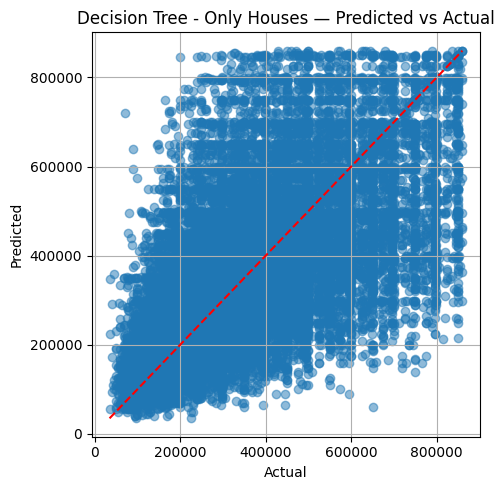

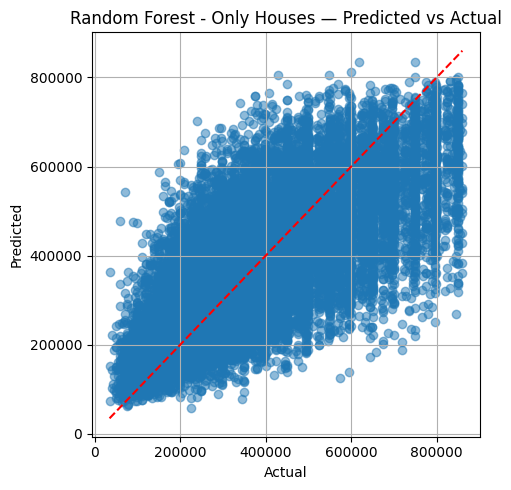

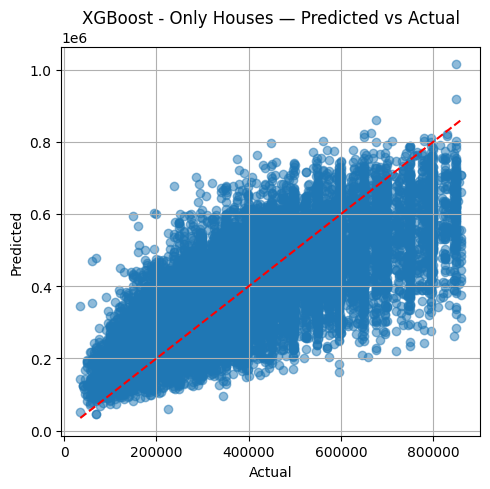

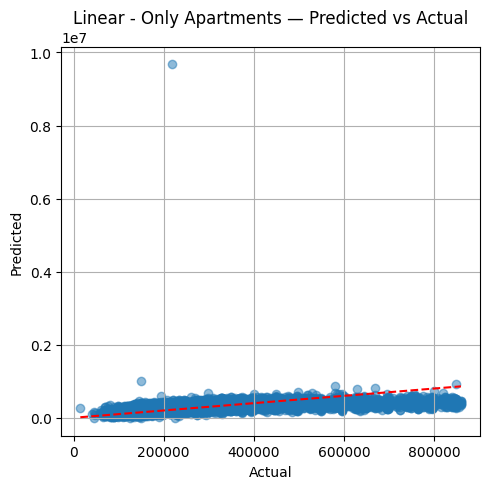

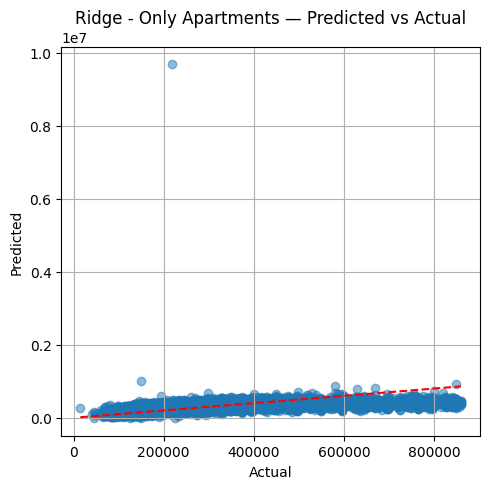

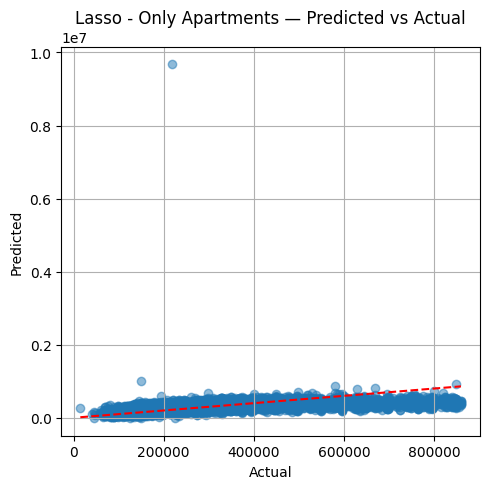

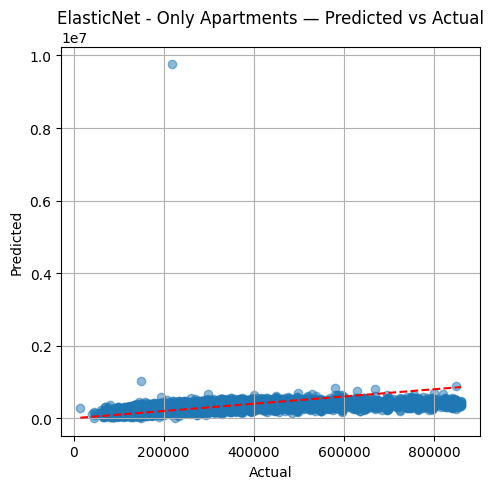

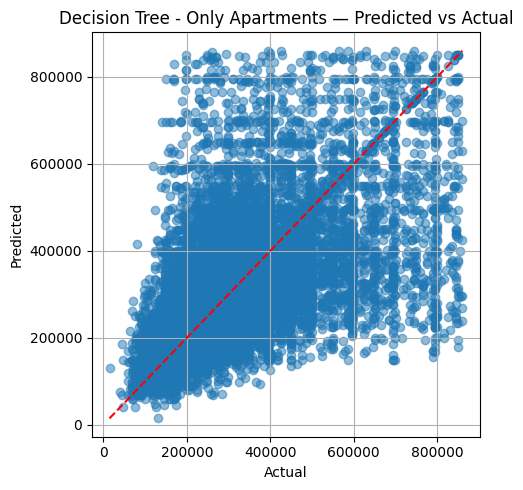

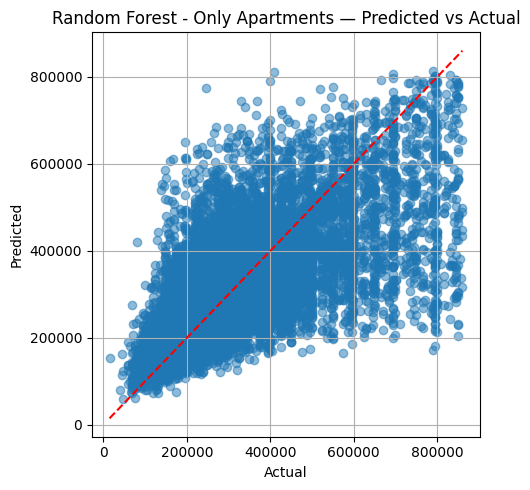

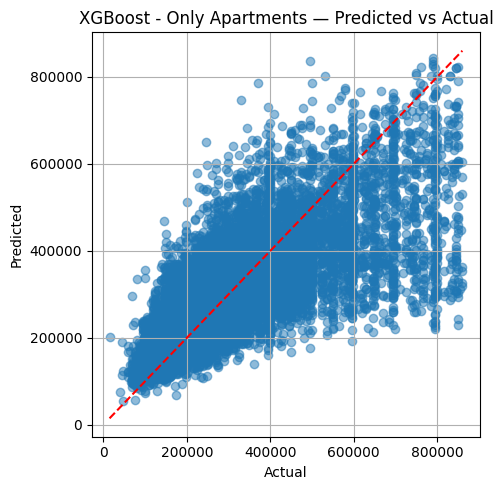


Summary of Regression Results:
            Dataset          Model  R² Score            MAE           RMSE
6    All Properties        XGBoost  0.571158   80139.222494  108743.386382
5    All Properties  Random Forest  0.507980   85252.631195  116478.441421
2    All Properties          Lasso  0.335292   94880.936885  135384.603044
0    All Properties         Linear  0.335292   94880.932540  135384.636118
1    All Properties          Ridge  0.335292   94881.000853  135384.649214
3    All Properties     ElasticNet  0.334552   95109.873227  135459.954230
4    All Properties  Decision Tree  0.250363  101897.849370  143773.666073
20  Only Apartments        XGBoost  0.517695   72184.035782  103390.766287
19  Only Apartments  Random Forest  0.443694   76914.870953  111039.500613
18  Only Apartments  Decision Tree  0.206541   89802.151354  132612.030883
16  Only Apartments          Lasso  0.106769   86503.325780  140702.784279
14  Only Apartments         Linear  0.106766   86503.336815  140702.

In [8]:
cv = KFold(n_splits=10, shuffle=True, random_state=123)

results = []

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Decision Tree": DecisionTreeRegressor(random_state=123),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=123),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=123)
}

datasets = {
    "All Properties": df_all,
    "Only Houses": df_hs,
    "Only Apartments": df_apt
}

for dataset_name, data in datasets.items():
    X, y = splitDF(data, target)

    for model_name, model in models.items():

        if model_name in ["Linear", "Ridge", "Lasso", "ElasticNet"]:
            pipeline = make_pipeline(StandardScaler(), model)
        else:
            pipeline = make_pipeline(model)

        y_pred = cross_val_predict(pipeline, X, y, cv=cv)
        regResults(dataset_name, model_name, y, y_pred)
        plotPredictions(dataset_name, model_name, y, y_pred)

results_df = pd.DataFrame(results)
print("\nSummary of Regression Results:")
print(results_df.sort_values(by=["Dataset", "RMSE"]))

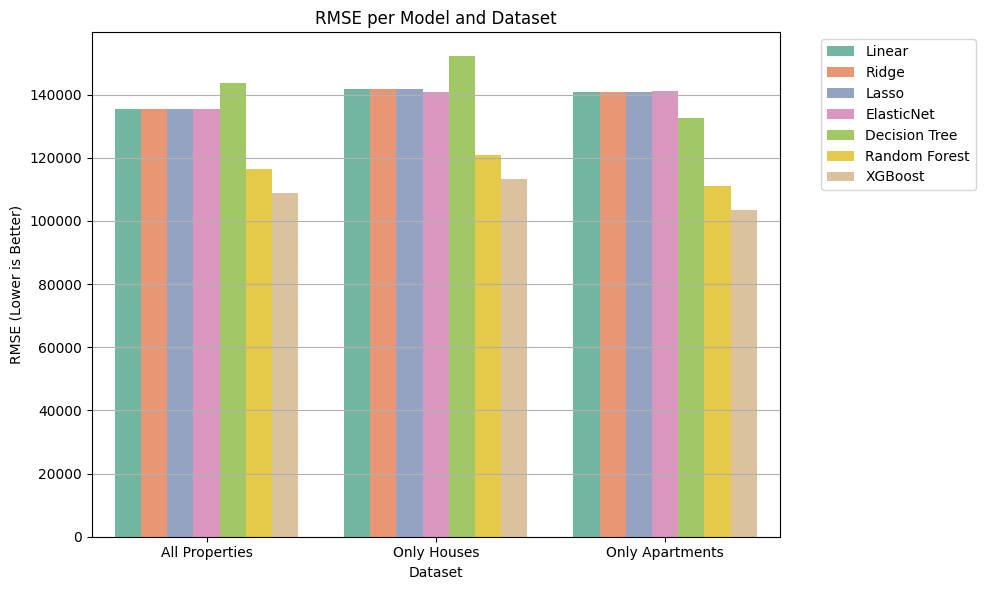

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=results_df,
    x="Dataset", y="RMSE", hue="Model",
    palette="Set2"
)
plt.title("RMSE per Model and Dataset")
plt.ylabel("RMSE (Lower is Better)")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

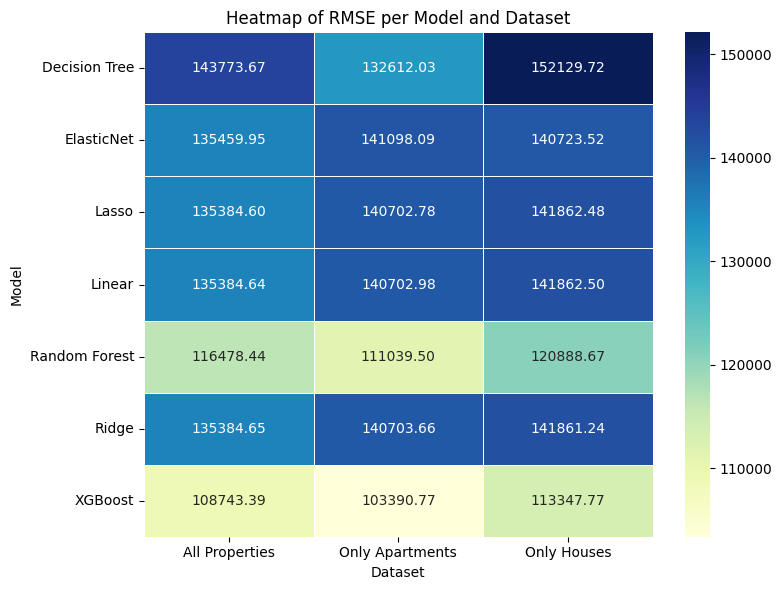

In [10]:
pivot_df = results_df.pivot(index="Model", columns="Dataset", values="RMSE")

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Heatmap of RMSE per Model and Dataset")
plt.ylabel("Model")
plt.xlabel("Dataset")
plt.tight_layout()
plt.show()
